In [3]:
def process_building_load(buildingLoadScaling):
    # Carica il file Excel
    file_path = r'C:\Users\metell1l\Desktop\Progetto_Edison\LucaEdison\Building_load.xlsx'
    df = pd.read_excel(file_path)

    # Rimuovi spazi bianchi dai valori della colonna "Time"
    df['Time'] = df['Time'].str.strip()

    # Converti la colonna "Time" in formato datetime
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

    # Imposta la colonna "Time" come indice
    df.set_index('Time', inplace=True)

    # Risample i dati ogni 5 minuti calcolando la media
    df_resampled = df.resample('5min').mean()

    # Converti la colonna "Potenza normalizzata [W]" in un vettore np.array
    potenza_norm_array = df_resampled['Potenza normalizzata [W]'].to_numpy()

    # Calcola il vettore di potenza giornaliero scalando il profilo sul massimo dell'edificio
    potenza_build_array = potenza_norm_array * buildingLoadScaling * 0.7

    return potenza_build_array

def process_pv_production():
    # Leggi il file Excel
    file_path = r'C:\Users\metell1l\Desktop\Progetto_Edison\LucaEdison\pv_production.xlsx'
    df = pd.read_excel(file_path)

    # Assicurati che le colonne abbiano i nomi corretti
    df.columns = ['Time', 'Value']

    # Converte i dati in un np.array
    original_values = np.array(df['Value'])

    # I tuoi dati originali ogni 15 minuti
    original_time = np.arange(0, 24, 0.25)  # ad esempio da 0 a 24 ore

    # Nuovi intervalli di tempo ogni 5 minuti
    new_time = np.arange(0, 24, 5/60.)  # da 0 a 24 ore, ogni 5 minuti

    # Usa numpy.interp per interpolare i nuovi valori
    new_values = np.interp(new_time, original_time, original_values)

    return new_values

def array_pun():
    # Carica il file Excel
    file_path=r'C:\Users\metell1l\Desktop\Progetto_Edison\LucaEdison\hourly_price_PUN.xlsx'
    df = pd.read_excel(file_path)
    
    # Supponiamo che la colonna dei prezzi orari si chiami '€/kWh'
    prezzi_orari = df['€/kWh'].values
    
    # Creiamo un array numpy che ripete ogni valore 12 volte (12 * 5 minuti = 1 ora)
    prezzi_5_minuti = np.repeat(prezzi_orari, 12)
    
    return prezzi_5_minuti

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def time_to_index(hour, minute):
    """Converte un orario (ora, minuto) in un indice del vettore (5 minuti)"""
    return (hour * 60 + minute) // 5

def create_schedule(connection_times, disconnection_times, num_stations=12, intervals_per_day=288):
    """
    Crea la schedule di connessione/disconnessione per le colonnine.
    
    Parameters:
    - connection_times: lista di liste di tuple (ora, minuto) per la connessione
    - disconnection_times: lista di liste di tuple (ora, minuto) per la disconnessione
    - num_stations: numero di colonnine
    - intervals_per_day: numero di intervalli di 5 minuti in un giorno (288)
    
    Returns:
    - schedules: array numpy di shape (num_stations, intervals_per_day) con i flag di connessione
    """
    schedules = np.zeros((num_stations, intervals_per_day), dtype=int)
    
    for i in range(num_stations):
        for conn, disc in zip(connection_times[i], disconnection_times[i]):
            conn_index = time_to_index(*conn)
            disc_index = time_to_index(*disc)
            if conn_index < disc_index:
                schedules[i, conn_index:disc_index] = 1
            else:  # gestione di connessione durante la notte (es. dalle 23:00 alle 02:00)
                schedules[i, conn_index:] = 1
                schedules[i, :disc_index] = 1
    
    return schedules

def calculate_residence_times(schedules):
    """
    Calcola il tempo di residenza (in minuti) per ogni colonnina.
    
    Parameters:
    - schedules: array numpy di shape (num_stations, intervals_per_day) con i flag di connessione
    
    Returns:
    - residence_times: array numpy con il tempo di residenza (in minuti) per ogni colonnina
    """
    intervals_per_day = schedules.shape[1]
    minutes_per_interval = 5
    
    # Calcola il numero di intervalli di connessione per ogni colonnina
    connection_intervals = np.sum(schedules, axis=1)
    
    # Converti il numero di intervalli in minuti
    residence_times = connection_intervals * minutes_per_interval
    
    return residence_times

def find_disconnection_times(extended_schedules):
    """
    Trova tutti gli istanti di tempo in cui per ogni colonnina si ha la disconnessione di un veicolo e
    restituisce un dizionario con le chiavi come indici delle colonnine e i valori come una lista dei timesteps
    di disconnessione.
    
    Parameters:
    - extended_schedules: array numpy di shape (num_stations, intervals_per_day) con i flag di connessione
    
    Returns:
    - disconnection_times: dizionario con le chiavi come indici delle colonnine e i valori come una lista dei timesteps di disconnessione
    """
    num_stations, intervals_per_day = extended_schedules.shape
    disconnection_times = {}
    
    for i in range(num_stations):
        station_schedule = extended_schedules[i]
        times = []
        
        # Trova tutti i punti di transizione da 1 a 0
        for t in range(1, intervals_per_day):
            if station_schedule[t-1] == 1 and station_schedule[t] == 0:
                times.append(t)
        
        # Se non ci sono disconnessioni, inserisci "0" se non ci sono mai connessioni
        if not times:
            if np.all(station_schedule == 0):
                disconnection_times[i] = [0]
            else:
                disconnection_times[i] = []
        else:
            disconnection_times[i] = times

    return disconnection_times


def calculate_final_soc(initial_soc, nominal_power, residence_times, battery_capacity, max_soc=0.7):
    """
    Calcola lo stato di carica finale per ogni veicolo.
    
    Parameters:
    - initial_soc: array numpy con lo stato di carica iniziale per ogni veicolo
    - nominal_power: array numpy con la potenza nominale della colonnina per ogni veicolo (kW)
    - residence_times: array numpy con il tempo di residenza (in minuti) per ogni veicolo
    - battery_capacity: array numpy con la capacità della batteria di ogni veicolo (kWh)
    - max_soc: lo stato di carica massimo consentito (default 0.7)
    
    Returns:
    - final_soc: array numpy con lo stato di carica finale per ogni veicolo
    """
    # Converti il tempo di residenza da minuti a ore
    residence_times_hours = residence_times / 60
    
    # Calcola l'incremento di carica per ogni veicolo
    charge_increment = (nominal_power * residence_times_hours) / battery_capacity
    
    # Calcola lo stato di carica finale
    final_soc = np.minimum(max_soc, 0.7*(initial_soc + charge_increment))
    
    return final_soc

def plot_schedule(schedules, num_stations=12):
    """
    Plot the schedules of multiple charging stations.

    Parameters:
    - schedules: numpy array with connection schedules
    - num_stations: number of charging stations (default: 12)
    """
    fig, axs = plt.subplots(num_stations, 1, figsize=(10, 15), sharex=True)
    time_slots = np.arange(schedules.shape[1])

    for i in range(num_stations):
        axs[i].step(time_slots, schedules[i], where='mid')
        axs[i].set_ylabel(f'Station {i+1}')
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_yticks([0, 1])
        axs[i].grid(True)

    axs[-1].set_xlabel('Time (5-minute intervals)')
    plt.tight_layout()
    plt.show()

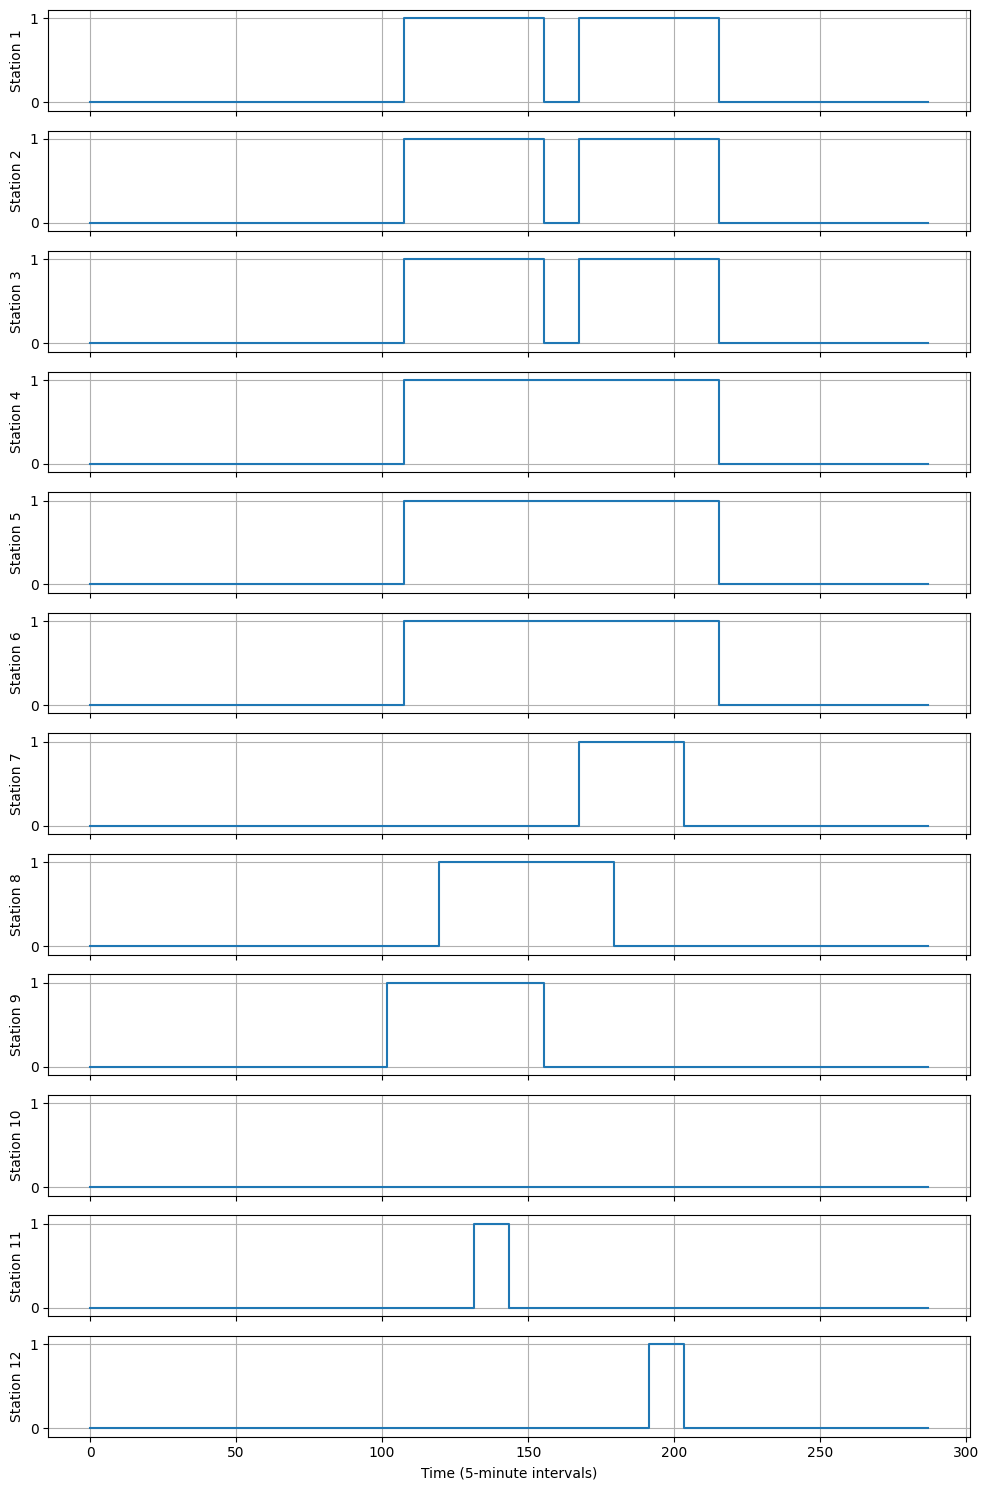

TypeError: loop of ufunc does not support argument 1 of type DivisionExpression which has no callable conjugate method

In [5]:
import pyomo.environ as pyo
from pyomo.environ import value
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import power_flow as pf

############ DEFINIZIONE DEI DATI DI INPUT ################

############# PROFILI DI CONSUMO O PRODUZIONE ##################

buildingLoadScaling= 378*0.95 #kW
timeStamp=1/12 #andiamo a creare dei timestamp della durata di 5 minuti, quindi 1/12 dell'ora
power_consumption=process_building_load(buildingLoadScaling)   #importo il profilo di carico giornaliero dell'edificio [kW]
power_pv=process_pv_production()   #importo il profilo di produzione giornaliero da pv [kW]

############# PROFILI DI COSTI/TARIFFE ######################

# dichiaro il vettore dei prezzi di acquisto dell'energia per ogni time step
spread=0.06   #spread sul prezzo dell'energia in €/kWh (maggiorazione del prezzo di acquisto rispetto a quello di vendita)
costi_in=(array_pun()+spread)*timeStamp #€ per l'energia data da 1kW per 5 minuti

# dichiaro il vettorie dei dei prezzi di vendita dell'energia per ogni time step
costi_out=array_pun()*timeStamp

#dichiaro poi il vettore dei prezzi di acquista dell'energia da parte degli utenti del parcheggio, scelti dal gestore
fee_AC=0.168 #€/kWh
fee_DC=0.168 #€/kWh

cost_AC=fee_AC*timeStamp  #costo in € per l'energia data da 1 kW per 5 minuti
cost_DC=fee_DC*timeStamp  #costo in € per l'energia data da 1 kW per 5 minuti

user_cost=np.array([cost_AC]*10+[cost_DC]*2)  #creao un array che definisce i costi per la ricarica in ogni colonnina (12 elementi)

################## DATI DI INPUT SUGLI UTENTI  ########################

#si deve definire anche un profilo temporale per ogni veicolo elettrico che ci dia indicazioni sul tempo di residenza degli EV
#le prime 6 righe rappresentano le schedule dei lavoratori fissi (colonnine AC)
#poi le 3 successive rappresentano i trasfertisti (colonnine AC)
#infine le ultime 2 righe rappresentano gli ospiti (colonnine DC)

connection_times = [
    [(9, 0), (14, 0)], 
    [(9, 0), (14, 0)], 
    [(9, 0), (14, 0)], 
    [(9, 0)], 
    [(9, 0)], 
    [(9, 0)], 
    [(14, 0)], 
    [(10, 0)], 
    [(8, 30)], 
    [(24, 0)], 
    [(11, 0)], 
    [(16, 0)]
]

disconnection_times = [
    [(13, 0), (18, 0)], 
    [(13, 0), (18, 0)], 
    [(13, 0), (18, 0)], 
    [(18, 0)], 
    [(18, 0)], 
    [(18, 0)], 
    [(17, 0)], 
    [(15, 0)], 
    [(13, 0)], 
    [(0, 0)], 
    [(12, 0)], 
    [(17, 0)]
]
#se una stazione di carica non verrà mai occupata si considera un tempo di connessione alle 24 e un tempo di disconnessione alle 0 (tempo di residenza nullo)
schedule = create_schedule(connection_times, disconnection_times)

# Plot schedule
plot_schedule(schedule)

# Calcola i tempi di residenza
residence_times = calculate_residence_times(schedule)

#si deve andare a contare la posizione che hanno gli istanti di distacco per i vari veicoli (servirà in seguito nell'assegnazione dei SoC minimi da rispettare al distacco)
disconnection_times=find_disconnection_times(schedule) #dizionario che contiene per ogni chiave (rappresenta l'i-esima colonnina), 
#delle liste contenenti l'indice del timestep in cui avviene la disconnesione del veicolo, relativo all'istante di tempo dell'attuale iterazione)

last_disconnection=[]

for i in range(len(user_cost)):
    last_disconnection.append(list(disconnection_times.values())[i][-1])
# Vengono definiti come valori noti lo stato di carica dei veicoli che arrivano presso le stazioni di carica del parcheggio
initial_soc=np.array([0.4,0.4,0.4,0.4,0.4,0.4,0.2,0.2,0.2,0,0.5,0.5])    #se una colonnina non verrà mai occupata si può imporre un initial soc pari a 0!

# Vengono definite le potenze massime dei veicoli per i funzionamenti in v2g e g2v
nominal_power=np.array([3.6,11,11,11,3.6,7.4,11,7.4,11,3.6,250,250])  #kW

#Vengono definite le capacità delle batterie di ogni veicolo che arriva nel parcheggio 
battery_capacity = np.array([13,42,75,42,13,26.8,75,26.8,75,13,42,75])  #kWh

####################### DATI DI INPUT SULLE COLLONNINE DI RICARICA #############################

#Definire numero colonnine 
nWB=12 
#set della potenza massima dei charging point
power_CP=np.array([22,22,22,22,22,22,22,22,22,50,50,50]) #kW

# dichiaro le efficienze dei caricabatterie
etaG2V=0.95
etaV2G=0.96

#si definisce un vettore per le potenze massime da rispettare di ricarica dei veicoli scelta tra il minore dei valori nominali 
#dati dalla colonnina di ricarica e il veicolo

PchMax_vehicles=[] # kW potenza carica massima dei veicoli

for i in range(len(power_CP)):
    if power_CP[i]<=nominal_power[i]:
        PchMax_vehicles.append(power_CP[i])
    else:
        PchMax_vehicles.append(nominal_power[i])
    
################ ATTENZIONE: I VALORI DI POTENZA DI SCARICA V2G SONO IMPOSTATI PER OGNI COLONNINA PARI A ZERO. SE SI METTESSERO VALORI NON NULLI ############
################ IL CODICE RISOLVEREBBE IL PROBLEMA CONSIDERANDO ANCHE IL V2G, MA NON TIENE CONTO DEL FATTO CHE CARICA E SCARICA NON POSSONO ESSERE SIMULTANEI!#######
############# C'E' UN PROBLEMA NELLA PARTE DI DEFINIZIONE DELLE VARIABILI NEL PROBLEMA DI OTTIMIZZAZIONE #############################

PdchMax_vehicles=[0,0,0,0,0,0,0,0,0,0,0,0] 

###########################################################

###################### DATI DI INPUT TEMPORALI #########################

nTimeStamp=len(power_pv) # conta il numero di istanti temporali

nSecDelayWb=5#in secondi
deadTimeCars=(1/3600)*nSecDelayWb#in ore
timeStampCars=timeStamp-deadTimeCars # considero la minore energia erogata come un time stamp più piccolo per erogare energia dalle auto dovuta al tempo di intervento delle WB

#################### DATI DI INPUT PER I VINCOLI DEL PROBLEMA ###################

# Calcolo i soc minimi da rispettare per le auto al momento del distacco dalle colonnine
final_soc = calculate_final_soc(initial_soc, PchMax_vehicles, residence_times, battery_capacity)

# Setto il massimo soc per i veicoli 
# Questa linea di codice crea una matrice bidimensionale SOC_max_vehicles che rappresenta i livelli massimi di carica 
# (SOC) delle batterie dei veicoli elettrici per tutti i timestamp considerati, impostandoli tutti a un valore costante di 0.9.
SOC_max_vehicles=[[0.9]*nTimeStamp]*nWB

# Definisco la massima potenza in e out dalla rete (uguale alla fornitura generalmente)
pGridInMax = 300 # kW
pGridOutMax = 250 # kW

############################################ PROBLEMA DI OTTIMIZZAZIONE ##########################################################

# Definisco il modello
model=pyo.ConcreteModel()

# Variables gridIn/Out
model.pGridIn=pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals) #Definisce una variabile continua non negativa per ogni timestamp (nTimeStamp) che rappresenta l'energia prelevata dalla rete.
model.pGridOut=pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals) #Definisce una variabile continua non negativa per ogni timestamp che rappresenta l'energia immessa nella rete.

# Variables EV
# Questa parte del codice definisce delle variabili di ottimizzazione aggiuntive per il modello Pyomo. 
# In particolare, queste variabili rappresentano l'energia trasferita dalla rete ai veicoli elettrici 
# (pG2V - Grid to Vehicle) per ciascun veicolo e per ciascun intervallo di tempo, l'energia sottratta ai veicoli e ceduta alla rete (pV2G)
#  e lo stato di carica dei veicoli in ogni istante di tempo.

for id, itm in enumerate([f'pG2V_car{idx}' for idx in range(nWB)]):
    # Funzione di inizializzazione per ogni variabile (opzionale, puoi definirla come vuoi)
    def init_val(model, t):
        return 0  # Inizializza con 0 per esempio (puoi usare anche un altro valore o una logica diversa)

    # Aggiungere la variabile con inizializzazione
    model.add_component(itm, pyo.Var(range(nTimeStamp), 
                                     within=pyo.NonNegativeReals, 
                                     bounds=(0, PchMax_vehicles[id]), 
                                     initialize=init_val))
    

for id, itm in enumerate([f'pV2G_car{idx}' for idx in range(nWB)]):
    # Funzione di inizializzazione per ogni variabile (opzionale, puoi definirla come vuoi)
    def init_val(model, t):
        return 0  # Inizializza con 0 per esempio (puoi usare anche un altro valore o una logica diversa)

    # Aggiungere la variabile con inizializzazione
    model.add_component(itm, pyo.Var(range(nTimeStamp), 
                                     within=pyo.NonNegativeReals, 
                                     bounds=(0, PdchMax_vehicles[id]), 
                                     initialize=init_val))

for itm in [f'SOC_car{idx}' for idx in range(nWB)]:
    model.add_component(itm,pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals))   

################################# Define objective function #####################################################################
def cost_function(model):
    cost_grid_in = sum(model.pGridIn[idx] * costi_in[idx] for idx in range(nTimeStamp))
    cost_grid_out = sum(model.pGridOut[idx] * costi_out[idx] for idx in range(nTimeStamp))
    
    # Calcolo del costo degli utenti per ogni timestamp
    costo_utenti_timestamp = []
    for idx in range(nTimeStamp):  
        costo_j = 0  # Inizializza il costo per questo timestamp
        for id in range(nWB):
            var_name = f'pG2V_car{id}'
            var_component = getattr(model, var_name)
            costo_j += var_component[idx] * user_cost[id]  # Accumula il costo per questo veicolo e timestamp
        costo_utenti_timestamp.append(costo_j)  # Aggiungi il costo totale di questo timestamp alla lista
    
    return cost_grid_in - cost_grid_out - sum(costo_utenti_timestamp)

model.obj=pyo.Objective(rule=cost_function, sense=pyo.minimize)

################################# Define equality constraints #####################################################################
# Assicura che la somma delle potenze prelevate, immesse, generate e consumate/dissipate sia bilanciata in ogni momento,
#  garantendo che l'energia sia conservata secondo il principio di conservazione dell'energia.
# A partire dall'equazioni di bilancio, si sono scritti tutti i flussi di potenza che in generale possono essere bidirezionali come
# un termine in ingresso e un termine in uscita, in modo che questi siano sempre valori positivi.

model.powerBalance = pyo.ConstraintList()
for i in range(nTimeStamp):
    exprex= - model.pGridIn[i] + model.pGridOut[i] - power_pv[i] + power_consumption[i]
    for itm in range(nWB): 
        exprex+=model.__dict__[f'pG2V_car{itm}'][i] - model.__dict__[f'pV2G_car{itm}'][i]  #aggiungo al bilancio 
        # anche le potenza prelevate e immesse da ogni veicolo elettrico
    model.powerBalance.add(expr=exprex==0)

################################# Define inequality constraints #####################################################################

# Vincoli sul SOC minimo per ogni veicolo in ogni timestamp (deve essere pari almeno al SoC con cui arriva il veicolo!)
model.minSOCconstr = pyo.ConstraintList()
for i in range(nTimeStamp):
    for itm in range(nWB):
        model.minSOCconstr.add(model.__dict__[f'SOC_car{itm}'][i] >= initial_soc[itm] * battery_capacity[itm])

# Vincoli sul SOC massimo per ogni veicolo in ogni timestamp (non può andare a saturare la batteria al di sopra del 0.9 per motivi di sicurezza!)
model.maxSOCconstr = pyo.ConstraintList()
for i in range(nTimeStamp):
    for itm in range(nWB):
        model.maxSOCconstr.add(model.__dict__[f'SOC_car{itm}'][i] <= SOC_max_vehicles[itm][i] * battery_capacity[itm])

# Definisci i vincoli sul SoC minimo per i veicoli al momento del distacco dalla stazione di carica
model.finalSOCconstr = pyo.ConstraintList()
for itm, index in enumerate(last_disconnection):
    model.finalSOCconstr.add(model.__dict__[f'SOC_car{itm}'][index]>= final_soc[itm]*battery_capacity[itm])

# Definisci i vincoli che spiegano al problema come eseguire il calcolo del SOC ad ogni passo temporale in funzione delle variabili calcolo di potenze di carica/scarica
def SOCcalc(model,i,itm):
    if i!=0:
        return model.__dict__[f'SOC_car{itm}'][i]==model.__dict__[f'SOC_car{itm}'][i-1]+(timeStampCars*(model.__dict__[f'pG2V_car{itm}'][i]*etaG2V -model.__dict__[f'pV2G_car{itm}'][i]/etaV2G))
    else:
        return  model.__dict__[f'SOC_car{itm}'][i]==initial_soc[itm]*battery_capacity[itm]+(timeStampCars*(model.__dict__[f'pG2V_car{itm}'][i]*etaG2V-model.__dict__[f'pV2G_car{itm}'][i]/etaV2G))

model.SOCcalc= pyo.ConstraintList()
for i in range(nTimeStamp):
    for itm in range(nWB):
            model.SOCcalc.add(SOCcalc(model,i,itm))

######################## Constraint sulle tensioni nodali accettabile per le colonnine durante l'esercizio ###############################

# Vincoli di tensione basati sui risultati del power flow
model.voltageConstraints = pyo.ConstraintList()

for i in range(nTimeStamp):
    # Estrai i valori di potenza da passare alla funzione power_flow
    power_G2V = [model.__dict__[f'pG2V_car{itm}'][i].value for itm in range(nWB)]
    power_V2G = [model.__dict__[f'pV2G_car{itm}'][i].value for itm in range(nWB)]
    
    # Calcolo delle tensioni nodali per questo timestamp
    voltages = pf.power_flow(power_G2V, power_V2G, power_pv[i], power_consumption[i])
    
    # Imporre i vincoli di tensione minima e massima
    for node, V in voltages.items():
        model.voltageConstraints.add(V >= 350)
        model.voltageConstraints.add(V <= 450)

######################## Constraint sulle potenze allocabili per le colonnine in e out ##################

# Definizione delle liste di vincoli
model.maxG2V = pyo.ConstraintList()
model.maxV2G = pyo.ConstraintList()

# Aggiungere i vincoli basati sulle schedule per cui potenza allocabile (per scarica o carica dell'EV) dovrà
#essere fissata a zero nei timestamp dove NON c'è una connessione di veicolo alla colonnina 

for i in range(nWB):
    for j in range(nTimeStamp):
        if schedule[i][j] == 0:
            # Se il veicolo non è connesso, la potenza deve essere zero
            model.maxG2V.add(model.__dict__[f'pG2V_car{i}'][j] == 0)
            model.maxV2G.add(model.__dict__[f'pV2G_car{i}'][j] == 0)
        else:
            # Se il veicolo è connesso, aggiungi i vincoli di potenza massima
            model.maxG2V.add(model.__dict__[f'pG2V_car{i}'][j] <= PchMax_vehicles[i])
            model.maxV2G.add(model.__dict__[f'pV2G_car{i}'][j] <= PdchMax_vehicles[i])


########## La seguente sezione è dedicata a rendere le variabili di grandezze bidirezionali mutualmente escludentesi,
# per cui un valore diverso da zero di una deve per forza annullare l'altro (non posso essere presenti contemporaneamente)############

######################## Constraint della rete in e out ###############

model.flag_dch_grid=pyo.Var(range(nTimeStamp), within=pyo.Binary)
model.flag_ch_grid=pyo.Var(range(nTimeStamp), within=pyo.Binary)

model.binaryGrid= pyo.ConstraintList()
for i in range(nTimeStamp):
    model.binaryGrid.add(expr=model.flag_ch_grid[i]+model.flag_dch_grid[i]<=1) 
#in questo modo si è fatto in modo di definire delle flag che fanno in modo che la grid_in e grid_out non siano
#contemporaneamente pari 1 (quindi che si preleva e immetta potenza dalla rete contemporaneamente)
model.maxGrid= pyo.ConstraintList()
for i in range(nTimeStamp):
    model.maxGrid.add(expr=model.pGridIn[i]<=model.flag_ch_grid[i]*pGridInMax)
    model.maxGrid.add(expr=model.pGridOut[i]<=model.flag_dch_grid[i]*pGridOutMax)


########################################## SOLVER #################################
# solver = pyo.SolverFactory('gurobi_direct')
solver = pyo.SolverFactory('glpk')

# Verifica dell'output del solver
results = solver.solve(model, tee=True)

if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    print("Soluzione ottimale trovata")
else:
    print(f"Stato del solver: {results.solver.status}")
    print(f"Condizione di terminazione del solver: {results.solver.termination_condition}")
    raise RuntimeError("Soluzione ottimale non trovata o si è verificato un altro problema")


# Inizializza le liste per memorizzare i valori delle variabili
pGridIn_values = []
pGridOut_values = []
pG2V_values = {f'pG2V_car{idx}': [] for idx in range(nWB)}
pV2G_values = {f'pV2G_car{idx}': [] for idx in range(nWB)}
SoC_values = {f'SOC_car{idx}': [] for idx in range(nWB)}

# Estrai i valori delle variabili
try:
    for t in range(nTimeStamp):
        pGridIn_values.append(pyo.value(model.pGridIn[t]))
        pGridOut_values.append(pyo.value(model.pGridOut[t]))
        for idx in range(nWB):
            pG2V_values[f'pG2V_car{idx}'].append(pyo.value(getattr(model, f'pG2V_car{idx}')[t]))
            pV2G_values[f'pV2G_car{idx}'].append(pyo.value(getattr(model, f'pV2G_car{idx}')[t]))
            SoC_values[f'SOC_car{idx}'].append(pyo.value(getattr(model, f'SOC_car{idx}')[t])/battery_capacity[idx])  #quando estraggo i valori per graficarli divido per la capacità della batteria per trovare il SoC in percentuale
except ValueError as e:
    print(f"Errore durante l'estrazione dei valori delle variabili: {e}")
    raise

# Crea
# Crea un DataFrame per i valori di pGridIn e pGridOut
df_grid = pd.DataFrame({
    'timestamp': range(nTimeStamp),
    'pGridIn': pGridIn_values,
    'pGridOut': pGridOut_values
})

# Crea DataFrame per i valori di pG2V, pV2G e SoC
df_pG2V = pd.DataFrame(pG2V_values)
df_pV2G = pd.DataFrame(pV2G_values)
df_SoC = pd.DataFrame(SoC_values)
df_pG2V['timestamp'] = range(nTimeStamp)
df_pV2G['timestamp'] = range(nTimeStamp)
df_SoC['timestamp'] = range(nTimeStamp)

# Grafico pGridIn e pGridOut
plt.figure(figsize=(10, 6))
plt.plot(df_grid['timestamp'], df_grid['pGridIn'], label='pGridIn', color='b')
plt.plot(df_grid['timestamp'], df_grid['pGridOut'], label='pGridOut', color='r')
#plt.plot(df_grid['timestamp'], power_consumption, label='pBuilding', color='g')
#plt.plot(df_grid['timestamp'], power_pv, label='pPV', color='y')
plt.xlabel('Timestamp')
plt.ylabel('Power (kW)')
plt.title('Power Grid In/Out Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Grafico pG2V per ogni veicolo
fig, ax1 = plt.subplots(figsize=(10, 6))

# Grafico pG2V per ogni veicolo
fig, ax1 = plt.subplots(figsize=(10, 6))

# Grafico per pG2V (asse sinistro)
for idx in range(nWB):
    ax1.plot(df_pG2V['timestamp'], df_pG2V[f'pG2V_car{idx}'], label=f'pG2V_car{idx}')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Power (kW)')
ax1.set_title('Power G2V for Each Vehicle Over Time')
ax1.grid(True)

# Crea il secondo asse Y (asse destro) per costi_in
ax2 = ax1.twinx()
ax2.plot(df_pG2V['timestamp'], costi_in, label='costi_in', color='red')
ax2.set_ylabel('Costi In (€)')

# Aggiungi la leggenda per entrambe le serie di dati
lines_labels_1 = ax1.get_legend_handles_labels()
lines_labels_2 = ax2.get_legend_handles_labels()

# Combina le etichette
lines = lines_labels_1[0] + lines_labels_2[0]
labels = lines_labels_1[1] + lines_labels_2[1]

# Posiziona la legenda fuori dal grafico e su più colonne
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

plt.tight_layout()
plt.show()

# Grafico pV2G per ogni veicolo
plt.figure(figsize=(10, 6))
for idx in range(nWB):
    plt.plot(df_pV2G['timestamp'], df_pV2G[f'pV2G_car{idx}'], label=f'pV2G_car{idx}')
plt.xlabel('Timestamp')
plt.ylabel('Power (kW)')
plt.title('Power V2G for Each Vehicle Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

# Grafico SoC per ogni veicolo
plt.figure(figsize=(10, 6))
for idx in range(nWB):
    plt.plot(df_SoC['timestamp'], df_SoC[f'SOC_car{idx}'], label=f'SOC_car{idx}')
plt.xlabel('Timestamp')
plt.ylabel('SoC (%)')
plt.title('State of Charge (SoC) for Each Vehicle Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

print(model.obj())

# Creiamo il grafico dei prezzi dell'energia
plt.figure(figsize=(10, 6))
plt.plot(costi_in, label='Costi In (€/5 min)', color='blue')
plt.plot(costi_out, label='Costi Out (€/5 min)', color='red')
plt.xlabel('Timestamp (ogni 5 minuti)')
plt.ylabel('Costo (€)')
plt.title('Costi di Acquisto e Vendita dell\'Energia')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
type(pG2V_values)

dict